In [52]:
import pandas as pd
import numpy as np
import torch
from torchvision import datasets,transforms,models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import random
import numpy as np
from PIL import Image
from sklearn.metrics import mean_squared_error as rmse
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import albumentations as A
import tqdm
from tqdm import trange,tqdm
from time import sleep
from sklearn.model_selection import train_test_split
!pip install timm
!pip install torchinfo
from torchinfo import summary
import timm

In [21]:
train = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
test = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
tidcol = test['Id']
idcol = train['Id']
direct1 = '../input/petfinder-pawpularity-score/train'
for i in range(idcol.shape[0]):
    idcol[i] = os.path.join(direct1, f'{idcol[i]}.jpg')
direct = '../input/petfinder-pawpularity-score/test'
for i in range(tidcol.shape[0]):
    tidcol[i] = os.path.join(direct, f'{tidcol[i]}.jpg')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [22]:
#  P<12.5 = 0
# 12.5 <= P < 37.5 = 1
# 37.5<=P <  62.5 = 2
# 62.5<P < 87.5  = 3
# P>=87.5 = 4
Y = []
for element in train['Pawpularity']:
    if element < 12.5:
        Y.append(0)
    elif 12.5<= element < 37.5 :
        Y.append(1)
    elif 37.5<= element < 62.5 :
        Y.append(2)
    elif 62.5<= element < 87.5 :
        Y.append(3)
    else:
        Y.append(4)
Y = np.array(Y)

In [23]:
X_train,X_val,y_train,y_val = train_test_split(train['Id'].values,Y,test_size = 0.15,random_state = 69)

In [24]:
class Pawpularity(Dataset):
    def __init__(self,path,targets=None,transform = None):
        self.path = path
        self.targets = targets
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self,idx):
        ipath = self.path[idx]
        image = Image.open(ipath)
        #image = cv2.imread(ipath)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #conv = transforms.ToTensor()
        #image = conv(image)
        #image = torch.rot90(image,1,[1,2])
        image = np.array(image)
        if self.transform is not None:
            al_dict = self.transform(image=image)
            image = al_dict['image']
        #print(image.size)
        
        conv = transforms.ToTensor()
        image = conv(image)
        image = torch.rot90(image,1,[1,2])
        if self.targets is not None :
            label = torch.tensor(self.targets[idx]).long()
            return image,label
        else :
            return image

In [25]:
transformT = A.Compose([
    A.SmallestMaxSize(240),
    A.RandomCrop(width=224 , height=224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Normalize(mean=(0.518, 0.484, 0.446), std=(0.264, 0.260, 0.261))
])
transformV = A.Compose([

    A.Resize(width=224 , height=224),
    A.Normalize(mean=(0.518, 0.484, 0.446), std=(0.264, 0.260, 0.261))
])

In [26]:
traindata = Pawpularity(path  = X_train,targets = y_train , transform = transformT)
valdata = Pawpularity(path = X_val,targets = y_val , transform = transformV)

In [27]:
def imageplot(dataset , count =3):
    plt.figure(figsize = (20,20))
    for i in range(count):
        rand = random.randint(0, len(dataset))
        #print(len(dataset))
        image,label = dataset[rand]
        plt.subplot(1, count, i%count +1)
        plt.axis('off')
        plt.imshow(image.permute(2, 1, 0))
        plt.title(f'Pawpularity: {label}')

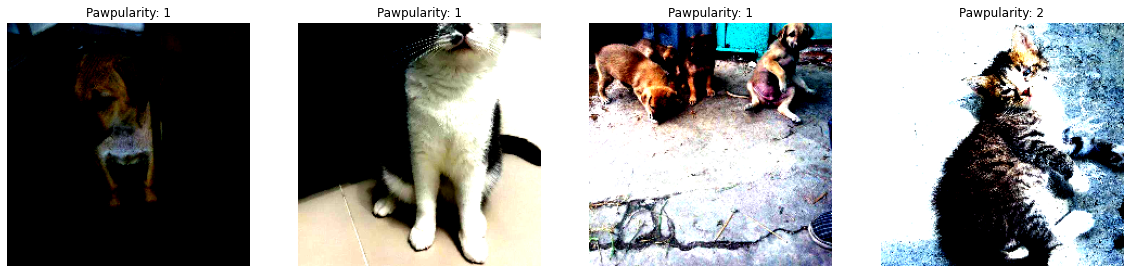

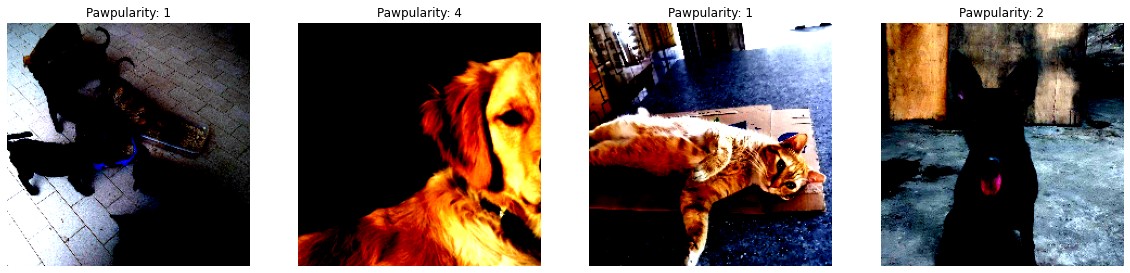

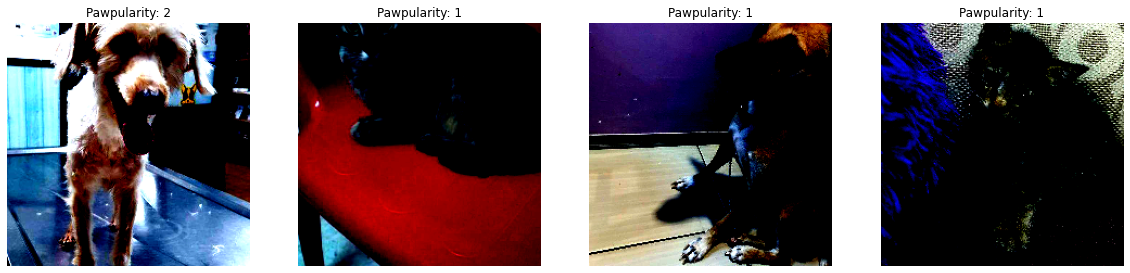

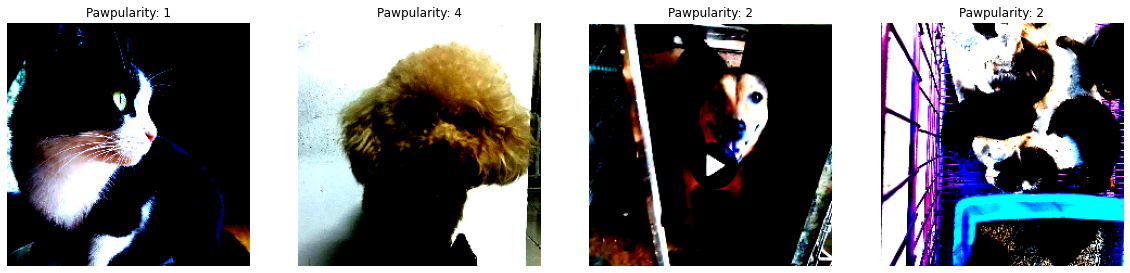

In [28]:
for i in range(4):
    imageplot(traindata,count=4)

In [29]:
train_loader = DataLoader(dataset=traindata, 
                          batch_size=32, 
                          shuffle=True)

val_loader = DataLoader(dataset=valdata, 
                         batch_size=32, 
                         shuffle=False)

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if(torch.cuda.is_available()):
  print("The device is " + torch.cuda.get_device_name())
else:
    print("Using cpu no gpu available")
print('\n',device)

The device is Tesla P100-PCIE-16GB

 cuda:0


In [31]:
all_densenet_models = timm.list_models('*resnet*')
all_densenet_models

['cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet200d',
 'ecaresnet269d',
 'ecaresnetlight',
 'ens_adv_inception_resnet_v2',
 'gcresnet50t',
 'geresnet50t',
 'gluon_resnet18_v1b',
 'gluon_resnet34_v1b',
 'gluon_resnet50_v1b',
 'gluon_resnet50_v1c',
 'gluon_resnet50_v1d',
 'gluon_resnet50_v1s',
 'gluon_resnet101_v1b',
 'gluon_resnet101_v1c',
 'gluon_resnet101_v1d',
 'gluon_resnet101_v1s',
 'gluon_resnet152_v1b',
 'gluon_resnet152_v1c',
 'gluon_resnet152_v1d',
 'gluon_resnet152_v1s',
 'inception_resnet_v2',
 'lambda_resnet26t',
 'lambda_resnet50t',
 'legacy_seresnet18',
 'legacy_seresnet34',
 'legacy_seresnet50',
 'legacy_seresnet101',
 'legacy_seresnet152',
 'nf_ecaresnet26',
 'nf_ecaresnet50',
 'nf_ecaresnet101',
 'nf_resnet26',
 'nf_resnet50',
 'nf_resnet101',
 'nf_seresnet26',
 'nf_seresnet50',
 'nf_seresnet101',
 'resnet18',
 'resnet18d',
 'resnet26',
 'r

In [59]:
r50 = timm.create_model('resnet50', pretrained=True)
#summary(r50, input_size=(16, 3, 224,224))

In [60]:
in_channels = r50.fc.in_features
cherry = nn.Sequential(
    nn.Linear(in_channels,1000),
    nn.ReLU(inplace = True),
    nn.BatchNorm1d(1000),
    nn.Dropout(0.5),
    nn.Linear(1000,5)
    )
r50.fc = cherry

In [61]:
metric = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(r50.parameters(),lr = 1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 3,
                                                        gamma = 0.1,verbose = True)


Adjusting learning rate of group 0 to 1.0000e-02.


In [62]:
def validate(model,dataloader):
    model = model.to(device)
    model = model.eval()
    scores = []
    targets = []
    with torch.no_grad():
        for bno ,(images,target) in enumerate(dataloader):
            images = images.to(device)
            target = target.to(device)
            score = model(images)
            a,b = score.shape
            target = torch.reshape(target,(a,1))
            targets.append(target.detach().cpu().numpy())
            pred = score.detach().cpu().numpy()
            pred = np.argmax(pred,axis = 1)
            scores.append(pred)
            del score,target,images
    targets = np.concatenate(targets,axis = 0) 
    scores  = np.concatenate(scores,axis = 0)
    accuracy = np.mean(targets==scores)*100
    return accuracy 

In [63]:
ep =[]
vacc =[]
tacc =[]
def trainer(model,optimizer,lossfn,scheduler,epochs,device,dataloader,val_loader=None):
    model.to(device)
    for epoch in range(epochs):
                print(f'Starting epoch {epoch+1}')
                current_loss = 0.0
                model = model.train()
                scores = []
                targets = []
                with tqdm(dataloader, unit="batch") as tepoch:
                    for images,target in tepoch:
                        tepoch.set_description(f"Epoch {epoch}")
                        images = images.to(device)
                        target = target.to(device)
                        score = model(images)
                        #print(score.shape,target.shape)
                        a,b = score.shape
                        target = torch.reshape(target,(a,))
                        loss = lossfn(score,target)
                        targets.append(target.detach().cpu().numpy())
                        scores.append(score.detach().cpu().numpy())
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        tepoch.set_postfix(loss=loss.item())
                        sleep(0.1)
                val_score = validate(model,val_loader)
                vacc.append(val_score)
                ep.append(epoch+1)
                scores = np.concatenate(scores,axis= 0)
                targets = np.concatenate(targets,axis = 0)
                scores = np.argmax(scores,axis = 1)
                train_score = np.mean(scores==targets)*100
                tacc.append(train_score)
                print(str(epoch+1) + ": validation acc : " + str(val_score))
                print(str(epoch +1) + " : train acc :" + str(train_score) )
                scheduler.step()
                print(optimizer.state_dict()['param_groups'][0]['lr'])
    return ep,vacc,tacc
                #torch.save(model,'/kaggle/working/model2.pth')   

In [64]:
a1,a2,a3= trainer(r50,optimizer,metric,scheduler,7,device,train_loader,val_loader)

Starting epoch 1


Epoch 0: 100%|██████████| 264/264 [03:15<00:00,  1.35batch/s, loss=2.85] 


1: validation acc : 52.95443270053081
1 : train acc :46.80118694362017
Adjusting learning rate of group 0 to 1.0000e-02.
0.01
Starting epoch 2


Epoch 1: 100%|██████████| 264/264 [03:16<00:00,  1.34batch/s, loss=1.39] 


2: validation acc : 55.99174011574873
2 : train acc :49.64985163204748
Adjusting learning rate of group 0 to 1.0000e-02.
0.01
Starting epoch 3


Epoch 2: 100%|██████████| 264/264 [03:02<00:00,  1.45batch/s, loss=1.21] 


3: validation acc : 56.18670486064159
3 : train acc :51.19287833827894
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Starting epoch 4


Epoch 3: 100%|██████████| 264/264 [03:09<00:00,  1.39batch/s, loss=1.99] 


4: validation acc : 56.09815441515325
4 : train acc :53.602373887240354
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Starting epoch 5


Epoch 4: 100%|██████████| 264/264 [03:00<00:00,  1.46batch/s, loss=0.94] 


5: validation acc : 56.016252036818535
5 : train acc :53.86350148367952
Adjusting learning rate of group 0 to 1.0000e-03.
0.001
Starting epoch 6


Epoch 5: 100%|██████████| 264/264 [02:59<00:00,  1.47batch/s, loss=1.26] 


6: validation acc : 55.861040020007515
6 : train acc :54.053412462908014
Adjusting learning rate of group 0 to 1.0000e-04.
0.0001
Starting epoch 7


Epoch 6: 100%|██████████| 264/264 [02:58<00:00,  1.48batch/s, loss=1.11] 


7: validation acc : 55.975730484644096
7 : train acc :54.124629080118694
Adjusting learning rate of group 0 to 1.0000e-04.
0.0001


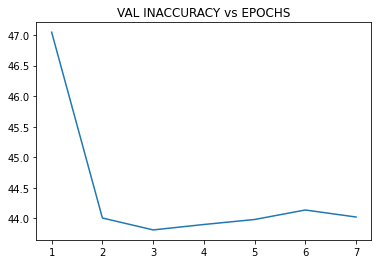

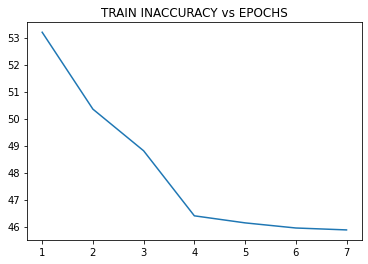

In [73]:
a1 = np.array(a1)
a2 = np.array(a2)
a3 = np.array(a3)
plt.title("VAL INACCURACY vs EPOCHS")
plt.plot(a1,100-a2)
plt.show()#validation INACCURACY vs epochs
plt.title("TRAIN INACCURACY vs EPOCHS")
plt.plot(a1,100-a3) #train INACCURACY vs epochs
plt.show()